<img style="float: right" src="https://github.com/profLewis/Geog2021_Coursework/raw/master/images/ucl_logo.png?raw=true">

# Data assimilation for an ecosystem model
## J Gómez-Dans (NCEO & UCL)

<div class=warn>
**Warning:** This notebook needs IPython 3!!!! Did you remember to type ``source activate ipy3`` before launching the notebook?
</div>

<div class=warn>
**Warning** If you're reading a rendered version of this notebook on e.g. nbviewer or github, some of the HTML controls will not show up and everything will look a bit weird.
<br >
**->** **Try** File->Trust Notebook
</div>

### Learning outcomes

This practical aims to

* introduce you to data assimilation, or blending observations and models in a consistent way,
* let you experiment with a generic vegetation carbon model,
* understand important concepts of data assimilation, and use a particle filter,
* explore observational and model uncertainty,
* think about how indirect observations can be helpful (or not!) for learning about the C cycle when going through a model.

The practical will make use of some code which is provided, and we expect that most of the interactions with the code will be through a simple web interface. There are a number of questions, indicated by green boxes, which you will need to think about, experiment with, and be ready to answer in the class.


### Introduction

Ecosystem models provide a description of the different physiological and ecological processes that control the evolution of the ecosystem. This means that they can model carbon and water fluxes, carbon stocks, etc. As you have seen in this course, this is a very challenging task, and necessarily, the models (like every model) will be *wrong*: processes will be simplified, missing or just assembled together in ways which are incorrect. In our interest in monitoring ecosystems, we are left with a model that can be very wrong.

A way to improve on this is to "correct" the model when observations are available, forcing the model to "track" the observations. Since observations are also imperfect (particularly the ones that we obtain from interpreting EO data), tracking the observations becomes a balancing act between how much one believes the model and how much one believes the observations. Ultimately, this is a decision that one makes based on the relative uncertainties of the model and observations: if the model is known to be very accurate, the observations are less relevant. Conversely, if the model is deemed to be a poor representation of reality, then the observations have a stronger weighting.

In this practical, we will explore the use of a complex Data Assimilation framework (the particle filter introduced in [Dowd *et al*, 2007](http://www2.geog.ucl.ac.uk/~mdisney/teaching/teachingNEW/methods/diff/Dowd.Bayesian_DA.JMSys.2007.pdf) to assimilate observations of leaf area index (LAI) from the [MODIS product](https://lpdaac.usgs.gov/products/modis_products_table/mod15a2) into the DALEC ecosystem model of [Williams *et al.*, 2005](http://www.geos.ed.ac.uk/home/homes/mwilliam/Williams05a.pdf) on the Metolius First Young Pine FLUXNET site in Oregon (US). You can see a Google Maps view of the site below, and you can find more information on the site in [FLUXNET](http://fluxnet.ornl.gov/site/958).

Note that this practical builds on the paper of [Quaife *et al*, (2008)](http://www2.geog.ucl.ac.uk/~mdisney/papers/Quaife_etal.EnKF.RSE.2008.pdf). The main differences is that we will be using a particle filter, and that, rather than using surface reflectance from MODIS directly (mapped into LAI using a radiative transfer model), we will assimilate the LAI product directly.


In [3]:
from IPython.display import IFrame
from IPython.core.display import display
google_maps_url = "http://maps.google.com/maps?q=44.4372+-121.5668&" + \
  "ie=UTF8&t=h&z=14&output=embed"
IFrame(google_maps_url,800,200)

### The DALEC model

The DALEC model is a surprisingly simple model that tracks the C in the ecosystem as it traverses a set of pools.

![DALEC diagram](http://ars.els-cdn.com/content/image/1-s2.0-S0034425707003276-gr2.jpg)

DALEC models GPP as a function of temperature, incoming shortwave radiation, vapour pressure deficit (moisture) and $CO_2$ concentration, using the ACM model (a simple model of daily photosynthesis). ACM is controlled by the following parameters (from [Williams et al, 2005](http://www.geos.ed.ac.uk/home/homes/mwilliam/Williams05a.pdf)), but also requires an estimate of $LAI$ to calculate interception of radiation by the canopy.

| Parameter 	| Term                                    	| Value  	|
|-----------	|-----------------------------------------	|--------	|
| a1        	| Nitrogen use efficiency (NUE) parameter 	| 2.155  	|
| a2        	| Day length coefficient                  	| 0.0142 	|
| a3        	| CO2 compensation point                  	| 217.9  	|
| a4        	| CO2 half saturation point               	| 0.980  	|
| a5        	| Midsummer coefficient                   	| 0.155  	|
| a6        	| Coefficient of hydraulic resistance     	| 2.653  	|
| a7        	| Maximum canopy quantum yield            	| 4.309  	|
| a8        	| Temperature coefficient of NUE          	| 0.060  	|
| a9        	| LAI-canopy quantum yield coefficient    	| 1.062  	|
| a10       	| Soil–leaf water potential exponent      	| 0.0006 	|


From GPP, the autotrophic respiration is subtracted, and NPP is allocated to the leaf, woody and root C pools ($C_f$, $C_w$ and $C_r$, respectively), following parameters $A_f$, $A_w$ and $A_r$. Leaves and roots decay into the litter pool ($C_lit$) (again controlled by parameters $L_f$ and $L_r$), whereas woody debris goes into the soil organic matter pool ($C_{SOM}$). The litter pool is eventually decomposed and added to the $C_{SOM}$ pool. The decomposition by microbes results in fluxes of heterotrophic respiration. The net ecosystem exchange is thus modelled as $NEE=GPP-R_a-R_{h1}-R_{h2}$.

These parameters are shown in the following table (taken from [Williams et al, 2005](http://www.geos.ed.ac.uk/home/homes/mwilliam/Williams05a.pdf)):

| Parameter 	| Term                                  	| Value        	|
|-----------	|---------------------------------------	|--------------	|
| $D$        	| Decomposition from litter to SOM      	| 4.41 × 10− 6 	|
| $R_a$         | Proportion of GPP lost to respiration 	| 0.4733       	|
| $A_f$        	| Proportion of NPP sent to foliage     	| 0.3150       	|
| $A_r$        	| Proportion of NPP sent to roots       	| 0.4344       	|
| $L_f$        	| Rate of leaf loss                     	| 0.002665     	|
| $L_w$        	| Rate of wood loss                     	| 2.06 × 10− 6 	|
| $L_r$        	| Rate of root loss                     	| 2.48 × 10− 3 	|
| $R_{h1}$     	| Rate of respiration from litter       	| 2.28 × 10− 2 	|
| $R_{h1}$   	| Rate of respiration from litter SOM   	| 2.65 × 10− 6 	|
| $C_f$        	| Initial foliar carbon pool            	| 57.705       	|
| $C_w$        	| Initial woody carbon pool             	| 769.86       	|
| $C_r$        	| Initial root carbon pool              	| 102.00       	|
| $C_{lit}$    	| Initial litter carbon pool            	| 40.449       	|
| $C_{SOM}$   	| Initial SOM carbon pool               	| 9896.7       	|


Let's see how the DALEC model works without any DA. The DALEC model is available from the [dalec.py](http://github.com/jgomezdans/blob/master/dalec.py) file, if you want to look at the code, and satisfy yourself that it really *is that* simple. Before we run the model test script, we will also set up some nice graphical options, as well as "uncompress" the observations files. Running the model is accomplished by using the ``test_dalec`` function. This provides a graphical output of the evolution of the different fluxes and pools. When available, independent ground observations will appear as back open circles.


/opt/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/opt/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  mplDeprecation)


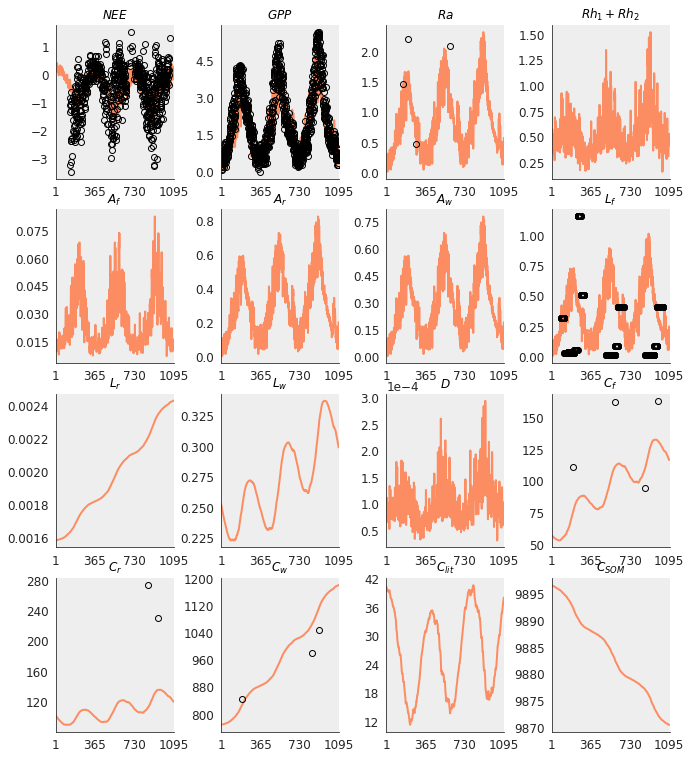

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from plot_utils import plot_config, plot_dalec

plot_config()

    
from dalec import *
%matplotlib inline

vanilla_dalec = test_dalec()
plot_dalec ( vanilla_dalec )


<div class=question>
* Do you see any patterns in the fluxes plots? What are they?
</div>


<div class=question>
* Is this site a C sink or a source?
</div>


<div class=question>
* Is this site in steady state?
</div>


<div class=question>
* What do the independent measurements on C pools and fluxes tell us about how DALEC is performing? For example, compare the GPP and NEE behaviour with the temporal evolution of other fluxes and/or pools where observations are available (e.g. $C_r$, $C_f$, ...)
</div>

### The DA scheme

In this practical, we shall be using a particular type of particle filter (PF), the one in [Dowd, (2007)](http://www2.geog.ucl.ac.uk/~mdisney/teaching/teachingNEW/methods/diff/Dowd.Bayesian_DA.JMSys.2007.pdf). This filter is slightly different from the usual particle filters that are often used in DA (see e.g. [Arulampalam (2002)](http://moodle.technion.ac.il/pluginfile.php/179706/mod_resource/content/0/2010/particle-filters1.pdf) for a tutorial introduction), but has nice properties. The Dowd PF filter is an extension of MCMC to sequential problems. As in any other Bayesian approach, it is based on two fundamental equations, dealing with state propagation and matching state and observations:


\begin{split}
    \mathbf{x}_{k+1} &= \mathcal{M}(\mathbf{x}_{k},I) + \nu\\
    \mathbf{y}_{k+1} &=\mathcal{H}(\mathbf{x}_{k+1},S) + \eta,
\end{split}
where the state vector at time $k$ (... $k+1$) is $\mathbf{x}_{k}$, the dynamic model (in this case, DALEC) is given by $\mathcal{M}$, and its function is to propagate the state vector forward in time, based on some drivers and parameters (here we note these by $I$). The observations at time $k$ are given by $\mathbf{y}_{k}$, and in order to map from the state to the observations, we need an *observation operator* $\mathcal{H}$, which might also require some extra parameters, noted here as $S$. Finally, we know that the model is only a model, so in propagating the state from one time to another, it will have an uncertainty, here expressed as $\nu$. Similarly, every observation has an error associated with, and we name it here $\eta$.

Solving these two equations together results in an estimate of the state vector that is consistent with the model *and* the observations (interpreted through the observation operator $\mathcal{H}$). Given the inherent noise in the observations and model, what we are after is a distribution of the state *conditioned* on the observations, which looks like this (Eq. 5 in Dowd 2007):

$$
p(\mathbf{x}_{k}|\mathbf{y}_{1:k})\propto p(\mathbf{y}_{k}|\mathbf{x}_{k}) \int p(\mathbf{x}_{k}|\mathbf{x}_{k-1})p(\mathbf{x}_{k-1}|\mathbf{y}_{1:(k-1})d\mathbf{x}_{k-1}.
$$

Although this equation looks hairy, it can be solved numerically following a fairly simple approach. PFs approximate the left hand side of this equation by a number of samples (particles), which makes the estimation problem tractable. Here's how this works:

* We generate a candidate state vector $\mathbf{x}_{k|k-1}^{*}$ by propagating a particle from the prior time step to the current time step using the DALEC model:

$$
\mathbf{x}_{k|k-1}^{*} = \mathcal{M}(\mathbf{x}_{k-1|k-1}^{*}, I_k) + \nu_k
$$

* We calculate the likelihood of the the candidate given the observations of LAI. We assume that the observation noise is Gaussian, and with a variance given by $\sigma_{obs,k}^2$ (this comes from the MODIS LAI product). Further, we use the fact that once we have propagated the model, we get an updated estimate for $C_f$ for time $k$ that we can convert into $LAI$ if we dividide it by the $LMA$ value:

$$
p(LAI_{k}|\mathbf{x}_{k|k-1}^{*})\propto \exp\left[ -\frac{( (C_{f,k}^{*}/LMA) - LAI_k)^2}{2\sigma_{obs,k}^2}\right]
$$

The previous step is just an indication of how well the selected particle, propagated by DALEC to the current time, matches the available observations of $LAI$, not forgetting that $LAI$ does have an error. Our observation operator here is just a simple division by the $LMA$ value, rather than a potentially complicated operator $\mathcal{H}$.

* We can now calculate the probability $\alpha$ of the candidate being accepted as particle $i$, using the Metropolis ratio:

$$
\alpha=\min\left( 1, \frac{ p(LAI_{k}|\mathbf{x}_{k|k-1}^{*}) }{p(LAI_{k}|\mathbf{x}_{k|k}^{i-1})}\right).
$$

* Particle $i$ thus has the following value, depending on the value of $\alpha$, that is selected by comparing it to $z\sim \mathcal{U}(0,1)$:

$$
\mathbf{x}_{k|k}^{i}=\begin{cases}
   \mathbf{x}_{k|k-1}^{*} & \text{if } z \leq \alpha \;\text{(Candidate is accepted)}\\
   \mathbf{x}_{k|k-1}^{i-1}       & \text{if } \ > \alpha \;\text{(Candidate not accepted. Use previous)}
  \end{cases}
$$

Note that if for a time period $k$ no observations are available, we just advance the model, and add the model noise. Also, note that we assume that the satellite $LAI$ measurement corresponds to the date it is marked on, when, in fact, that measurement typically corresponds to an 8-day period.

Dowd gives the pseudo-code in an appendix of his paper, which you might find helpful:

![pseudocode of the PF](PF_pseudocode.png)

The python code that performs the assimilation is in the [``sequentialMH.py``](https://github.com/jgomezdans/dalec_pf/blob/master/sequentialMH.py) file, in particular in the ``assimilate`` function (check the signature of that function to see what parmeters are used for default in running the assimilation). 

A simple assimilation can be done as follows using the ``assimilate`` method on [``sequentialMH.py``](https://github.com/jgomezdans/dalec_pf/blob/master/sequentialMH.py). This will take a while, but will produce a number of plots:

1. A plot of model LAI compared with MODIS LAI observations
2. A plot of fluxes (GPP, NEE, autotrophic and heterotrophic respiration)
3. A plot of the temporal evolution of C pools
4. A plot of internal fluxes within DALEC

Where available, ground data will be plotted as well as black open circles, so you can compare directly other independent measurements with the result of the assimilation. The original DALEC fluxes/pools will be plotted as a black dashed line

We will start running the filter with 250 particles, as this has been proved useful. The model errors by default are set to around 10% of the initial pool estimates, and the initial pool estimates come from the papers cited at the top.

Note that the DA run will take a bit, some 2-3 minutes, so please be patient. 

/home/ucfajlg/python/dalec_pf/sequentialMH.py:162: RuntimeWarning: divide by zero encountered in true_divide
  0.5*( lai - obs)**2/obs_unc**2
/home/ucfajlg/python/dalec_pf/sequentialMH.py:302: RuntimeWarning: invalid value encountered in subtract
  alpha = min ( 1, np.exp ( log_proposed - log_prev ) )


Assimilation done in 13 seconds


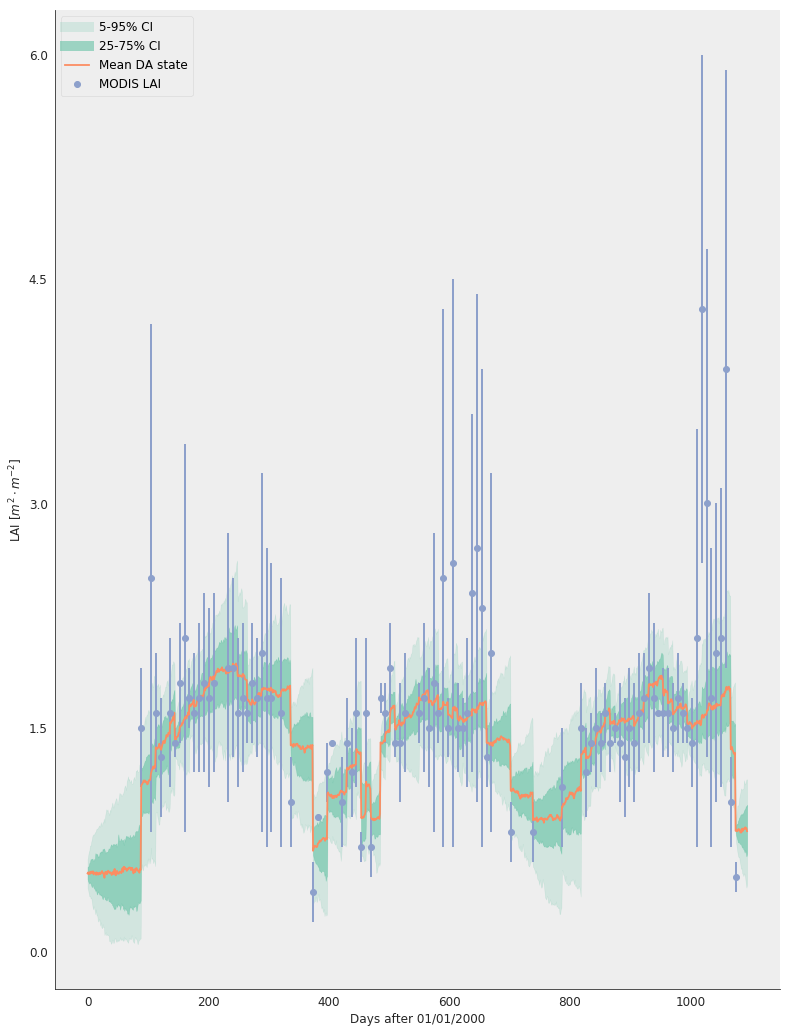

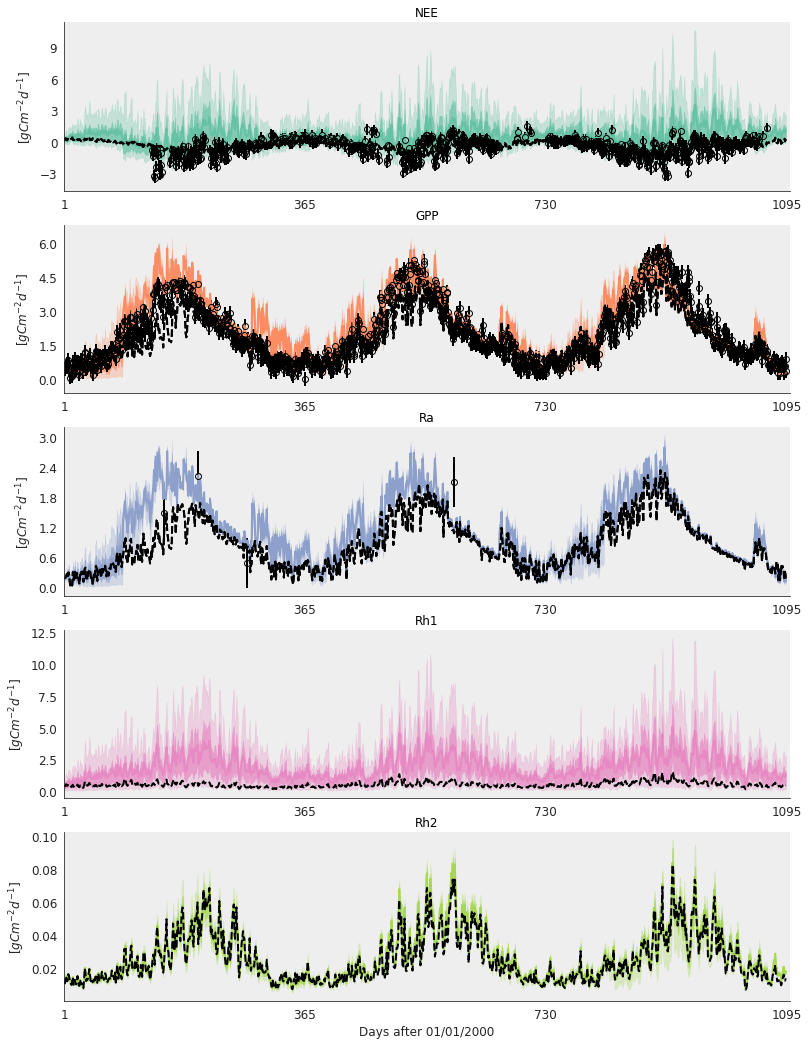

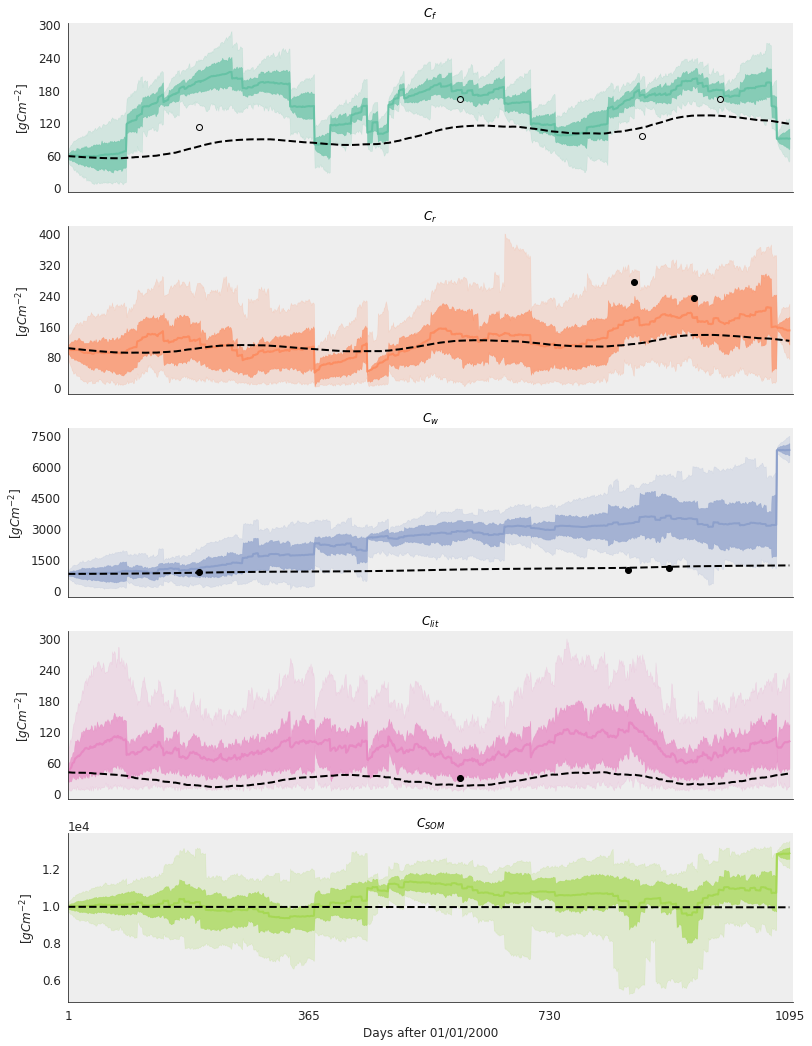

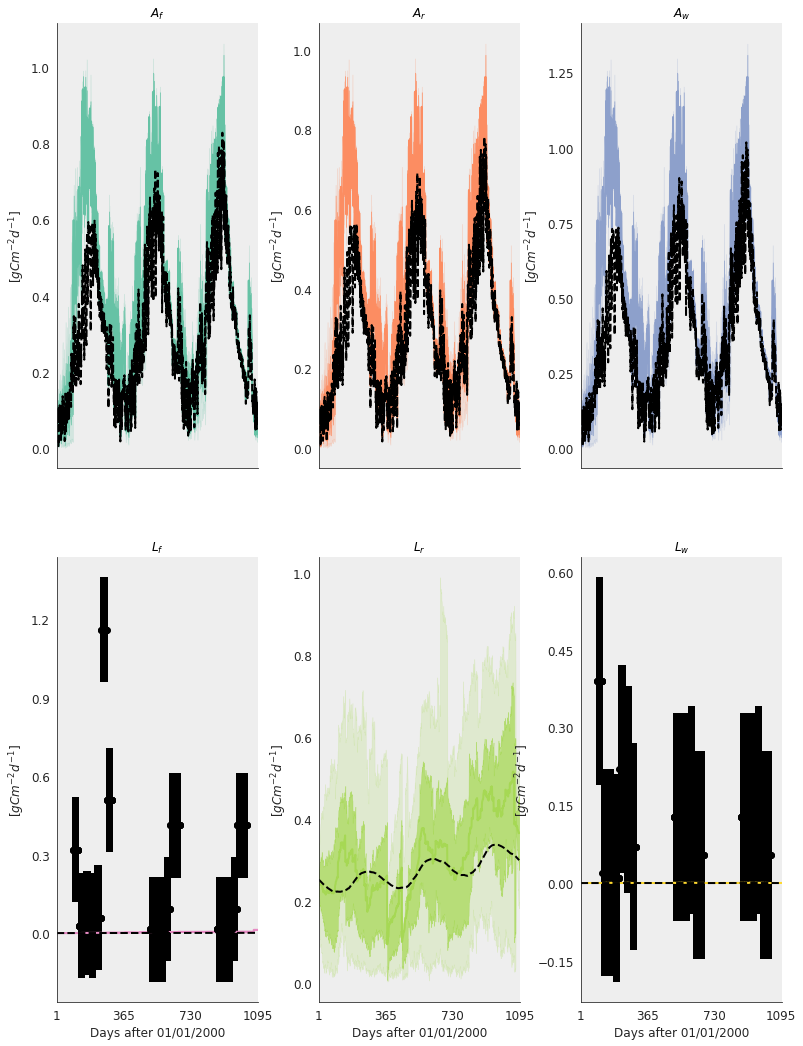

In [5]:
from sequentialMH import assimilate_and_plot
DALEC, observations, results = assimilate_and_plot ( n_particles=50 )

<div class=question>
It is interesting to look at the evolution of $C_f$ for both the assimilation and no assimilation examples. Think how we couple the $LAI$ observations to DALEC, and try to explain why the difference in the two trajectories.
</div>

<div class=question>
In the first plot, do you think we have some MODIS LAI observations that might be outliers? 
</div>

<div class=question>
In the first plot, try to explain the shape of the uncertainty shaded area in green.
</div>

Let's look at the LAI evolution and the effect of the PF on it. To do this, we will focus on the first 150 days, and will plot the trajectories of all the particles, the observations,and also the original DALEC run, which we called above ``vanilla_dalec``:

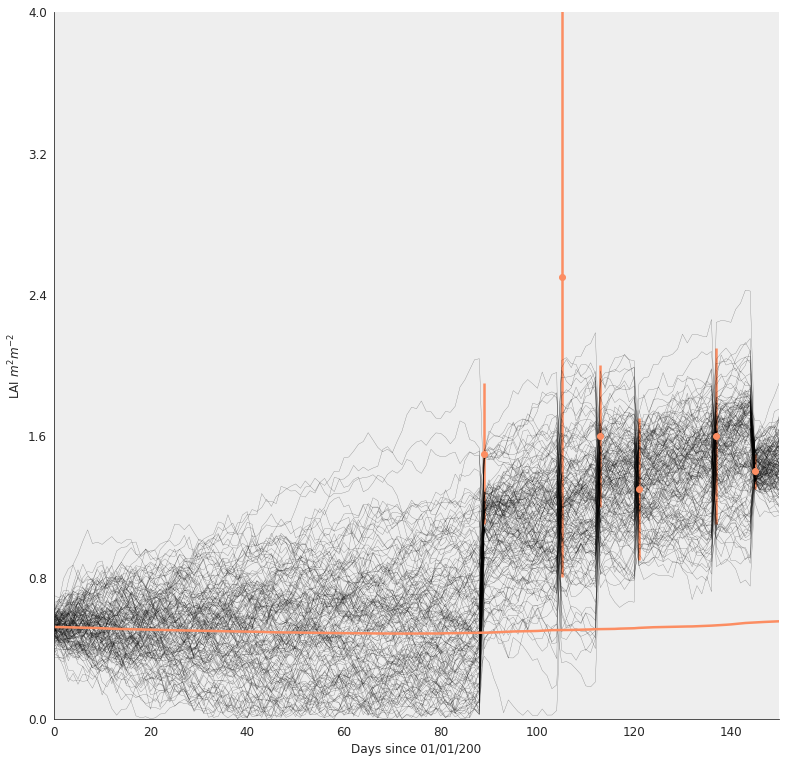

In [6]:
from plot_utils import pretty_axes


plt.figure(figsize=(13,13))
plt.plot(np.arange(1095), results[:,:, -5]/110., '-k', lw=0.3, alpha=0.5)
plt.plot(np.arange(1096), vanilla_dalec[-1, :], '-', lw=2.5)

plt.xlim(0,150)
plt.ylim ( 0, 4 )
plt.xlabel("Days since 01/01/200")
plt.ylabel("LAI $m^{2}m^{-2}$")
plt.plot ( observations.fluxes['lai'][:,0], observations.fluxes['lai'][:,1], 
          'o', c="#FC8D62" )
plt.vlines ( observations.fluxes['lai'][:,0], 
            observations.fluxes['lai'][:,1] - observations.fluxes['lai'][:,2], 
            observations.fluxes['lai'][:,1] + observations.fluxes['lai'][:,2], 
            lw=2.5, color="#FC8D62" )
pretty_axes(plt.gca() )

We see that from the start of the assimilation, the LAI uncertainty increases. This is a consequence of having a model error (remember $\nu$ in the equations above?): as we go forward in time, this means that the error accumulates and we are less and less certain of the model. 
Then, after day 80, we get an observation, and immediately, we see that the particle filter *nudges* the predicted LAI upwards to meet the data. As the observation is quite noisy, the model output is not entirely within the observation uncertainty: we have some level of confidence in the model, and a single uncertain observation is not enough to completely shift the solution. Interestingly, the second observation is a poor quality observation (note the massive error bars), so it does not have a major impact on the assimilated trajectory. As the third and further observations arrive, we see that the particles start to be broadly distributed around the observations, indicating that the model is able to reproduce their distribution. This is in stark contrast to the open model run, shown above in green, which basically stays at around $LAI=0.5$.

<div class=question>
From the comparisons with the observations above (redone here so they are a bit easier to see), comment on what you think is happening. In particular, try to look at the trajectory of LAI and see how that affects GPP, as LAI will have a clear bearing on GPP. Consider how DALEC was calibrated for this particular same site.
</div>

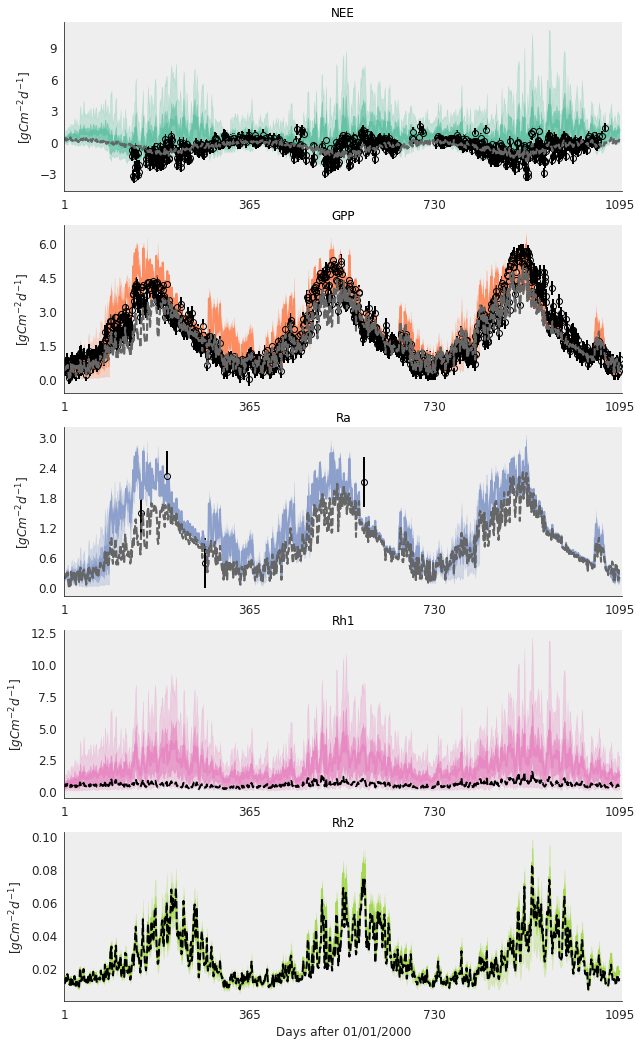

In [7]:
from plot_utils import plot_fluxes
plot_fluxes ( DALEC, results )

## Experiments with the PF

In the previous example, we just run a preconfigured particle filter. You now have a chance to experiment with the different parameters that go into it. Broadly these are:

**SLA**
: The specific leaf area value, nominally set to 110 $g/m^2$

**Number of particles**
: Number of particles in the PF. For computational reasons, we go for the lowest possible number, but this is a parameter that will differ from problem to problem. Try values between 10 and 1000, for example.

**Starting pool values** 
: We need to set the starting pools values to something. Things like the foliar C pool will react very dynamically to LAI observations, but what about the other pools? Try changing the values and see what happens

**Model uncertainty**
: As we move from time $t$ to time $t+1$, we add noise to the state, and these parameters add how much noise is added to the different pools. Initially, we start at around 10% of the original pool values, but depending on what you choose, the assimilation will give wildly different results.

**Assimilation streams**
: A number of other observations, independent of MODIS LAI are available for quite a number of different pools for Metolius. You can assimilate these, rather than LAI or choose to assimilate everything together.

**MODIS LAI** changes
: One interesting thing to do is to be able to scale the reported MODIS LAI uncertainty by a scalar. You could also thin the observations, or choose to only assimilate MODIS observations for a reduced period of time (e.g. for one year, rather than 3). These tweaks allow you to see what the effect of "starving" the assimilation  of data is, either by reducing the data by thinning or subsetting, or by degrading its information content by inflating its uncertainty.

<div class=question>
You may want to keep a record of your experiments to answer some of the questions below. You can do that here on this notebook (just replicate the next cell for each experiment), or you can copy and paste the plots somewhere.
</div>


In [2]:
from ipywidgets import interact_manual
import ipywidgets as widgets
%matplotlib inline
#from IPython.html import widgets
from sequentialMH import assimilate_and_plot
_ = interact_manual ( assimilate_and_plot, sla=(10,300.), n_particles=(10,2000), 
                 Cf0=widgets.FloatSlider(min=1, max=500, value=58. ), 
                 Cr0=widgets.FloatSlider(min=1, max=500, value=102. ),
                 Cw0=widgets.FloatSlider(min=200, max=1000, value=770. ),
                 Clit0=widgets.FloatSlider(min=10, max=150, value=40. ),
                 Csom0=widgets.FloatSlider(min=7000, max=12000, value=9897. ),
                 Cfunc=widgets.BoundedFloatText(min=1,max=50, value=5.8, description="Cf Unc"),
                 Crunc=widgets.BoundedFloatText(min=1,max=30, value=10, description="Cr Unc"),
                 Cwunc=widgets.BoundedFloatText(min=20,max=100, value=77., description="Cw Unc"),
                 Clitunc=widgets.BoundedFloatText(min=1,max=15, value=4, description="Clit Unc"),
                 Csomunc=widgets.BoundedFloatText(min=700,max=1200, value=100, description="Csom Unc"),
                 do_lai=widgets.Checkbox(description="Use MODIS LAI", value=True ),
                 do_cf=widgets.Checkbox(description="Use Cf meas", value=False ),
                 do_cw=widgets.Checkbox(description="Use Cw meas", value=False ),
                 do_cr=widgets.Checkbox(description="Use Cr meas", value=False ),
                 do_cl=widgets.Checkbox(description="Use Cl meas", value=False ),
                 do_csom=widgets.Checkbox(description="Use Csom meas", value=False),
                 thin_lai=widgets.IntSlider ( min=0, max=10, value=0, description="Thin MODIS LAI data"),
                 lai_start=widgets.IntSlider ( min=0, max=1096, value=0, description="Starting date for MODIS LAI"),
                 lai_end=widgets.IntSlider ( min=0, max=1096, value=1096, description="End date for MODIS LAI"),
                 lai_unc_scalar=widgets.FloatSlider ( min=0.01, max=100, value=1, description="Scale LAI uncertainty")
)

interactive(children=(FloatSlider(value=110.0, description='sla', max=300.0, min=10.0), IntSlider(value=25, description='n_particles', max=2000, min=10), FloatSlider(value=58.0, description='Cf0', max=500.0, min=1.0), FloatSlider(value=102.0, description='Cr0', max=500.0, min=1.0), FloatSlider(value=770.0, description='Cw0', max=1000.0, min=200.0), FloatSlider(value=40.0, description='Clit0', max=150.0, min=10.0), FloatSlider(value=9897.0, description='Csom0', max=12000.0, min=7000.0), BoundedFloatText(value=5.8, description='Cf Unc', max=50.0, min=1.0), BoundedFloatText(value=10.0, description='Cr Unc', max=30.0, min=1.0), BoundedFloatText(value=77.0, description='Cw Unc', min=20.0), BoundedFloatText(value=4.0, description='Clit Unc', max=15.0, min=1.0), BoundedFloatText(value=700.0, description='Csom Unc', max=1200.0, min=700.0), Checkbox(value=True, description='Use MODIS LAI'), Checkbox(value=False, description='Use Cw meas'), Checkbox(value=False, description='Use Cr meas'), Checkbox(value=False, description='Use Cf meas'), Checkbox(value=False, description='Use Cl meas'), Checkbox(value=False, description='Use Csom meas'), IntSlider(value=0, description='lai_thin', max=1), IntSlider(value=0, description='Starting date for MODIS LAI', max=1096), IntSlider(value=1096, description='End date for MODIS LAI', max=1096), FloatSlider(value=1.0, description='Scale LAI uncertainty', min=0.01), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<div class=question>
Change the uncertainty in the MODIS LAI data (this basically scales the satellite product's reported uncertainty). Try a very low value (e.g. 0.01) and a very high value (e.g. 100). What do you observe?
</div>

<div class=question>
Change the starting value of the foliar C pool, $C_{f0}$, and set the model uncertainty for $C_f$ to be low (e.g. 1). Explain what you see.
</div>

<div class=question>
What happens if you set the uncertainty in the model in $C_f$ to be very large? 
</div>

<div class=question>
Experiment by switching off the MODIS LAI measurements, and assimilate ground measurements of e.g. $C_f$, $C_w$ or $C_l$. Note that these measurements are much sparser. Comment on what you see, and relate it to the ability of the observations to constrain the model.
</div>

<div class=question>
Both the ground measurements of $C_f$ and the MODIS LAI measurements are nominally giving us insight on $C_f$. Try assimilating each observational stream independently, both, and comment on what you see. Now consider the conversion from LAI to $C_f$, through the value of SLA. Remember the huge variability in SLA shown in Kattge et al (2011) (see [here in the notes](http://www2.geog.ucl.ac.uk/~plewis/geogg124/modelling.html#plant-functional-types)). What are the implications of that?
</div>

### Final points

Hopefully, the previous experiments will have introduced you to using a simple ecosystem C model. You should think how this simple model relates to the ideas you have seen of LSMs in this course, and assess its utility.

Secondly, you have also had experience using an advanced DA scheme. You should be able to see how this particle filter works (you can get even more detail by just looking at how the assimilation step is implemented in the ``assimilate_obs`` method in ``sequentialMH.py``).

Finally, you should now be aware of the importance of **uncertainty** in working with models, data, etc. 

<div class=question>
... Which begs a final question. How do we assess uncertainty, both in observations **and** for the model? Can you think of practical ways to assess either of these uncertainties?
</div>

In [9]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()